In [1]:
import numpy as np
import pandas as pd
import glob

from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:

import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

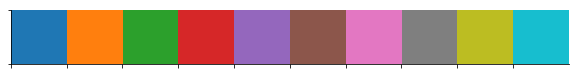

In [59]:
import seaborn as sns
sns.palplot(sns.color_palette())


In [60]:
green = sns.color_palette()[2]
red = sns.color_palette()[3]

# PG Bookshelves
We use PG bookshelves as labels, see here [here](http://www.gutenberg.org/wiki/Category:Bookshelf).
They are better than the 'genre' metadata field. **WHY???**

This notebook uses the bookshelves generated in the main `gutenberg` repo.
For a more self-contained, older version, see `notebooks/old/Bookshelves_generation.ipynb`.

### Statistics before filtering BS

In [40]:
df = pd.read_pickle("../../gutenberg-frozen-2018-07-18/metadata/bookshelves_raw.p")

In [41]:
import sys
sys.path.append("../../gutenberg/src/")
from metaquery import meta_query
mq = meta_query(path="../../gutenberg-frozen-2018-07-18/metadata/metadata.csv")

In [42]:
# restrict to books we have
bookswehave = mq.df.id.values
new_idx = (np.intersect1d(df.index, bookswehave))
df = df.loc[new_idx]

In [43]:
# how many books and bs
df.shape

(12078, 236)

In [44]:
# how many books are part of how many bookshelves
Counter(df.sum(axis=1))

Counter({1.0: 10426, 2.0: 1450, 3.0: 170, 4.0: 28, 5.0: 4})

In [45]:
x = np.array(list(list(zip(*sorted(list(Counter(df.sum(axis=1)).items()))))[1]))
x = x/np.sum(x)

/home/fontclos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


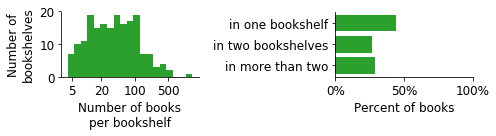

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2), tight_layout=True)
color = green

ax = ax2
ax.barh(range(3)[::-1], [x[0], x[1], np.sum(x[2:])], color=color)
ax.set_yticks(range(3))
ax.set_yticklabels(["in more than two", "in two bookshelves", "in one bookshelf"])
ax.set_xlabel("Percent of books")
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1][::2])
ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"][::2])
fig.savefig("../figures/bookshelves_per_book.pdf")

bs_sizes = df.sum().sort_values(ascending=False)

bs_sizes = bs_sizes.loc[bs_sizes>4]

ax = ax1
bins = np.linspace(0.6, 3.2, num=20)
ax.hist(np.log10(bs_sizes), bins=bins, color=color);
xticks = [5, 20, 100, 500]
ax.set_xticks([np.log10(x) for x in xticks])
ax.set_xticklabels(xticks)
ax.set_xlabel("Number of books\nper bookshelf")
ax.set_ylabel("Number of\nbookshelves")
fig.savefig("../figures/stats_bookshelf.pdf")

In [48]:
list_subjects = [[k for k in h.strip("{}")[1:-1].replace("', '","_").split('_')] for h in mq.df['subjects'].replace('set()',np.nan).dropna()]

In [49]:
subjects_per_book = mq.df['subjects'].replace('set()',np.nan).dropna().apply(lambda x:len([k for k in x.strip("{}")[1:-1].replace("', '","_").split('_')])).values
books_per_subject = list(mq.get_subjects_counts().values())

/home/fontclos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


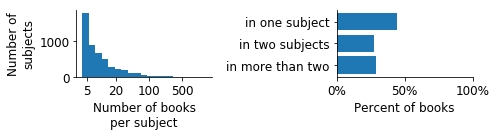

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2), tight_layout=True)

bins = np.linspace(0.6, 3.2, num=20)

ax = ax1
ax.hist(np.log10(books_per_subject), bins=bins);
xticks = [5, 20, 100, 500]
ax.set_xticks([np.log10(x) for x in xticks])
ax.set_xticklabels(xticks)
ax.set_xlabel("Number of books\nper subject")
ax.set_ylabel("Number of\nsubjects")
fig.savefig("../figures/books_per_subject.pdf")

x = np.array(list(list(zip(*sorted(list(Counter(subjects_per_book).items()))))[1]))
x = x/np.sum(x)
ax = ax2
ax.barh(range(3)[::-1], [x[0], x[1], np.sum(x[2:])])
ax.set_yticks(range(3))
ax.set_yticklabels(["in more than two", "in two subjects", "in one subject"])
ax.set_xlabel("Percent of books",)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels(["0%", "50%",  "100%"])
fig.savefig("../figures/stats_subjects.pdf")